In [9]:
import os
import glob
import rasterio as rio
from rasterio.windows import Window
import rasterio.plot as rp


if "GOOGLE_APPLICATION_CREDENTIALS" not in os.environ:
    adcfiles = glob.glob(f"{os.environ['HOME']}/.config/gcloud/legacy_credentials/*/adc.json")
    if len(adcfiles)==1:
        print(f"using {adcfiles[0]} for GCP credentials")
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=adcfiles[0]
    else:
        raise Exception("no GCP credentials found, have you run 'gcloud auth login' ?")




Inspecter la liste des tuiles S2 disponibles:

    gsutil ls -l gs://tb-be-bigdata/t31tcj/

et selectionner une tuile pour faire quelques visualisations (choisir une tuile plutot grosse afin
de ne pas tomber sur une tuile completement nuageuse ou partiellement couverte).

In [3]:
s2_tile='gs://tb-be-bigdata/t31tcj/T31TCJ_20230709T104629_TCI.tif'

with rio.open(s2_tile) as st:
    print(f'size = {st.width}x{st.height} pixels')
    print(f'{len(st.indexes)} bands (channels) of type {st.dtypes[0]}')
    print(f'bounds = {st.bounds}')
    print(f'projection = {st.crs}')
    

size = 10980x10980 pixels
3 bands (channels) of type uint8
bounds = BoundingBox(left=300000.0, bottom=4790220.0, right=409800.0, top=4900020.0)
projection = EPSG:32631


La quantité de données à visualiser est trop grosse pour être affichée confortablement en pleine résolution
(i.e. sans avoir à trop attendre et/ou sans consommer trop de temps cpu)

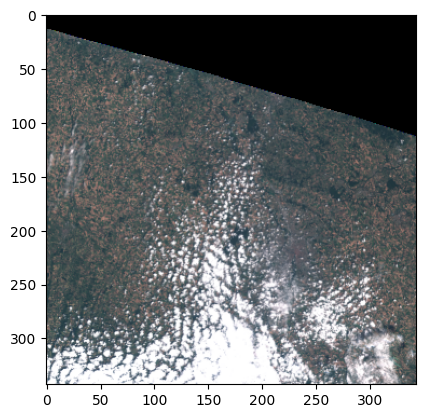

In [4]:
#affichons la donnée complete depuis une overview (=une version sous-echantillonnée précalculée)
#https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html#rasterio.io.DatasetReader.read
with rio.open(s2_tile) as st:
    ovr = st.read(out_shape=(3,st.height//32,st.width//32))
    rp.show(ovr)

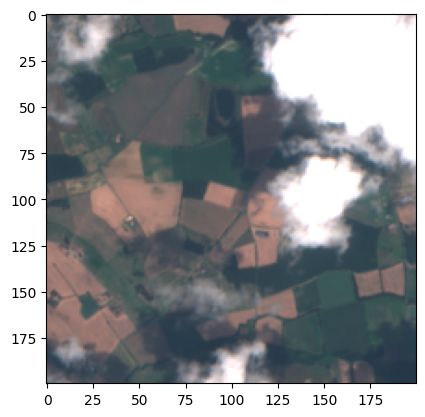

In [5]:
#affichons un extrait de 200x200px en pleine resolution
# https://rasterio.readthedocs.io/en/stable/api/rasterio.windows.html#rasterio.windows.Window
with rio.open(s2_tile) as st:
    extract = st.read(window=Window(5000,5000,200,200), out_shape=(3,200,200))
    rp.show(extract)



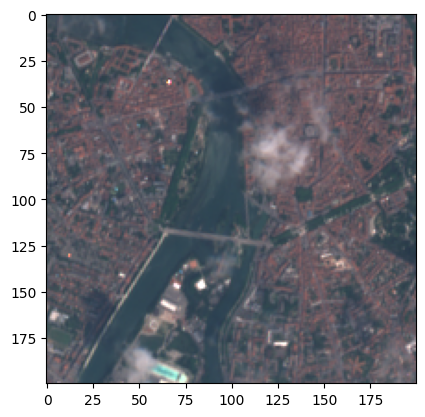

In [6]:
# affichons un extrait de 200x200px autour du centre de toulouse (longitude=1.4395871 latitude=43.5943521)
# https://pyproj4.github.io/pyproj/stable/examples.html#transformations-from-crs-to-crs
# https://github.com/rasterio/affine
from pyproj import CRS
from pyproj import Transformer
with rio.open(s2_tile) as st:
    transformer = Transformer.from_crs('EPSG:4326', st.crs) #EPSG:4326 is lat/lon
    utm_x, utm_y = transformer.transform(43.5943521,1.4395871)
    utm_to_pix = ~st.transform
    pix_x,pix_y = utm_to_pix*(utm_x,utm_y)
    extract = st.read(window=Window(pix_x-100,pix_y-100,200,200))
    rp.show(extract)

# worker

suivre les instructions du README afin de deployer un service autoscalable permettant de traiter des taches de
traitement d'image en parallele.

# dispatcher

ce code permet de generer les payloads JSON permettant de traiter l'ensemble de l'image, en decoupant à la tuile de
1024x1024

In [27]:
from google.cloud import storage
from google.cloud import pubsub_v1
import json
import requests
import base64

GCPPROJECT="solar-climber-412810"
TOPIC="bebigdata"
RESULTS="gs://tb-be-bigdata/results-py/"

storage_client = storage.Client(project=GCPPROJECT)
pubsub_client = pubsub_v1.PublisherClient()
topic_name = f'projects/{GCPPROJECT}/topics/{TOPIC}'
#

s2tiles = list(storage_client.list_blobs("tb-be-bigdata",prefix="t31tcj/"))
s2tiles = [f"gs://tb-be-bigdata/{b.name}" for b in s2tiles if b.name.endswith("TCI.tif")]

tilesize=1024
image_height=10980
image_width=10980
# for testing/debugging, only launch a single tile
image_height=1024
image_width=1024

for x in range(0,image_width,tilesize):
    tile_width = tilesize
    if x+tilesize > image_width:
        tile_width = image_width - x
    for y in range(0,image_height,tilesize):
        tile_height = tilesize
        if y+tilesize > image_height:
            tile_height = image_height - y
        
        payload = {
            "datasets": s2tiles,
            "window": [x,y,tile_width,tile_height],
            "destination": f"{RESULTS}tile_{x}_{y}.tif",
            #"destination": f"tile_{x}_{y}.tif",

        }

        # pubsub version
        #future = pubsub_client.publish(topic_name, json.dumps(payload).encode("utf-8"))
        #future.result()
        #continue

        # local http version
        http_payload = {
            "message": {
                "data": str(base64.b64encode(json.dumps(payload).encode("utf-8")), "utf-8")
            }
        }
        data=json.dumps(http_payload)
        resp = requests.post(f"http://localhost:8080/median", data=data , headers={"Content-Type":"application/json"})
        print(resp.text)


# visualisation du résultat

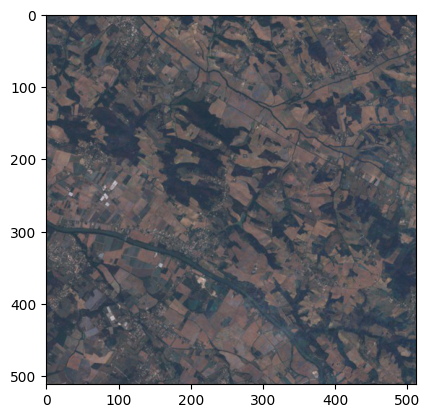

In [7]:
result_tile = "gs://tb-be-bigdata/results-py/tile_7168_3072.tif"
with rio.open(result_tile) as st:
    extract = st.read(out_shape=(3,512,512))
    rp.show(extract)


recontruction d'une image COG complete assemblant chacune des tuiles individuelles

In [11]:
import subprocess
from google.cloud.storage.blob import Blob
from google.cloud import storage

GCPPROJECT="solar-climber-412810"

storage_client = storage.Client(project=GCPPROJECT)
#

result_tiles = list(storage_client.list_blobs("tb-be-bigdata",prefix="results-py/"))
result_tiles = [f"gs://tb-be-bigdata/{b.name}" for b in result_tiles if b.name.endswith(".tif")]
f = open("results.lst","w")
for t in result_tiles:
    local_file = t.split("/")[-1]
    blob = Blob.from_string(t, storage_client)
    blob.download_to_filename(local_file)
    f.write(f"{local_file}\n")
f.close()

!gdalbuildvrt -input_file_list results.lst results.vrt

with rio.open("results.vrt") as st:
    profile = st.profile
    profile["driver"]="COG"
    profile["compress"]="JPEG"
    profile["tiled"]=True
    profile["blocksize"]=256
    profile["quality"]=90
    with rio.open("results.tif", "w", **profile) as dst:
        dst.write(st.read())

for t in result_tiles:
    local_file = t.split("/")[-1]
    os.remove(local_file)
os.remove("results.lst")
os.remove("results.vrt")
blob = Blob.from_string("gs://tb-be-bigdata/median.tif", storage_client)
blob.upload_from_filename("results.tif")
os.remove("results.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.


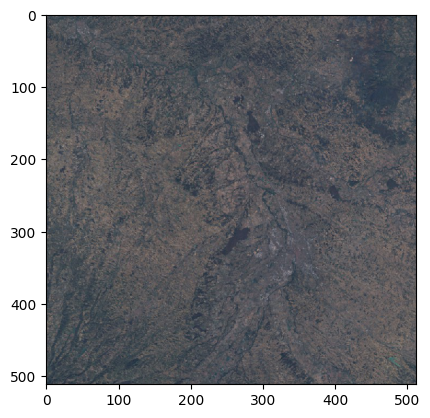

In [37]:
median_result = "gs://tb-be-bigdata/median.tif"
with rio.open(median_result) as st:
    overview = st.read(out_shape=(3,512,512))
    rp.show(overview)